In [1]:
from objects import RouteManager, EventManager
from helpers import *
import matplotlib.pyplot as plt
import seaborn as sns

## do nothing scenario

In [2]:
route = RouteManager()
event = EventManager()
event.start_vehicles(route)
route.load_all_pax()

steps = 0
done, reward, next_state = event.step(route, action=True)
while steps < 55:
    event.step(route, action=True)
    steps += 1

In [3]:
event.timestamps[-1]

8473.0

In [4]:
pax_hist = get_pax_hist(route, FLEX_STOPS)
veh_hist = get_veh_hist(route, FLEX_STOPS)

In [5]:
## ridership
pax_hist.groupby(['flex']).size()

flex
0    209
dtype: int64

<AxesSubplot: >

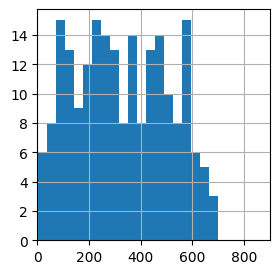

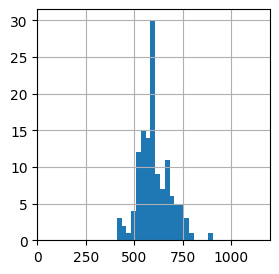

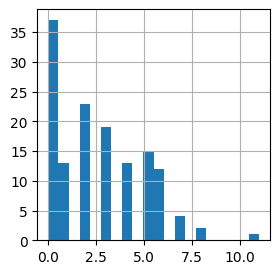

In [6]:
fig, axs = plt.subplots(figsize=(3,3))
pax_hist[~pax_hist['origin'].isin([FLEX_STOPS])]['wait_time'].hist(ax=axs, bins=20)
axs.set_xlim(0, 900)

fig, axs = plt.subplots(figsize=(3,3))
veh_hist['headway'].hist(ax=axs, bins=20)
axs.set_xlim(0, 1200)

fig, axs = plt.subplots(figsize=(3,3))
veh_hist['load'].hist(ax=axs, bins=20)

## scenario with serve all pax

In [7]:
route = RouteManager()
event = EventManager()
event.start_vehicles(route)
route.load_all_pax()

steps = 0
done, reward, next_state = event.step(route, action=True)
while steps < 50:
    n_pax = next_state[0]
    if n_pax:
        done, reward, next_state = event.step(route, action=False)
    else:
        done, reward, next_state = event.step(route, action=True)
    steps += 1

In [9]:
pax_hist = get_pax_hist(route, FLEX_STOPS)
veh_hist = get_veh_hist(route, FLEX_STOPS)

In [10]:
event.timestamps[-1]

8478.0

In [11]:
## ridership
pax_hist.groupby(['flex']).size()

flex
0    203
1     51
dtype: int64

<AxesSubplot: >

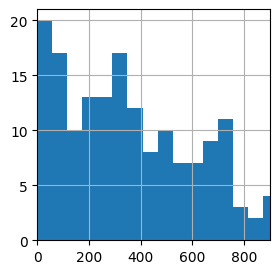

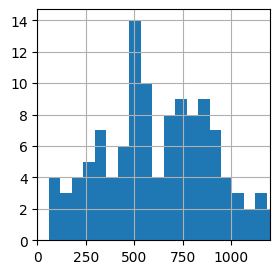

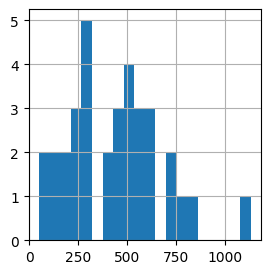

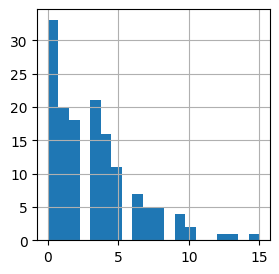

In [48]:
fig, axs = plt.subplots(figsize=(3,3))
pax_hist[~pax_hist['origin'].isin(FLEX_STOPS)]['wait_time'].hist(ax=axs, bins=20)
axs.set_xlim(0, 900)

fig, axs = plt.subplots(figsize=(3,3))
veh_hist[~veh_hist['stop'].isin(FLEX_STOPS)]['headway'].hist(ax=axs, bins=20)
axs.set_xlim(0, 1200)

fig, axs = plt.subplots(figsize=(3,3))
pax_hist[pax_hist['origin'].isin(FLEX_STOPS)]['wait_time'].hist(ax=axs, bins=20)

fig, axs = plt.subplots(figsize=(3,3))
veh_hist['load'].hist(ax=axs, bins=20)
# axs.set_xlim(0, 900)

## process results

## debugging

In [15]:
for direction in ('in', 'out'):
    for s in route.stops[direction]:
        if s.active_pax:
            print([(direction, p.origin, p.destination, p.arrival_time) for p in s.active_pax])

[('in', 0, 1, 6164.0)]
[('in', 2, 3, 157.0), ('in', 2, 3, 426.0), ('in', 2, 5, 1115.0), ('in', 2, 6, 1444.0), ('in', 2, 3, 1701.0), ('in', 2, 6, 2410.0), ('in', 2, 6, 2869.0), ('in', 2, 3, 3366.0)]
[('in', 3, 6, 5696.0)]
[('in', 4, 6, 280.0), ('in', 4, 5, 1974.0), ('in', 4, 6, 2670.0), ('in', 4, 6, 4121.0), ('in', 4, 6, 4718.0), ('in', 4, 5, 5348.0), ('in', 4, 6, 5610.0), ('in', 4, 6, 5662.0)]
[('in', 5, 6, 5756.0), ('in', 5, 6, 5878.0), ('in', 5, 6, 6040.0)]
[('out', 0, 1, 6008.0)]
[('out', 2, 3, 202.0), ('out', 2, 5, 893.0), ('out', 2, 6, 3028.0), ('out', 2, 6, 3718.0), ('out', 2, 3, 5718.0), ('out', 2, 6, 5863.0)]
[('out', 4, 6, 139.0), ('out', 4, 6, 1168.0), ('out', 4, 6, 2023.0), ('out', 4, 6, 2190.0), ('out', 4, 6, 2901.0), ('out', 4, 5, 3079.0), ('out', 4, 5, 3605.0), ('out', 4, 5, 4359.0), ('out', 4, 6, 4575.0), ('out', 4, 6, 5305.0), ('out', 4, 6, 5748.0)]


In [16]:
for veh in route.vehicles:
    print(veh.direction)
    print(veh.event)
    print([(p.origin, p.destination, p.arrival_time, p.boarding_time) for p in veh.pax])

out
{'last': {'time': 6152.0, 'type': 'depart', 'stop': 1}, 'next': {'time': 6223.0, 'type': 'arrive', 'stop': 3}}
[(0, 3, 5681.0, 6000), (0, 6, 5923.0, 6000), (1, 5, 6091.0, 6145.0)]
in
{'last': {'time': 6192.0, 'type': 'arrive', 'stop': 1}, 'next': {'time': 6199.0, 'type': 'depart', 'stop': 1}}
[(0, 6, 5461.0, 6089.0), (0, 3, 5472.0, 6089.0), (1, 6, 5701.0, 6192.0)]


In [27]:
veh_df[veh_df['veh_id']==1].sort_values(by=['arrival_time'])

,direction,stop,arrival_time,departure_time,load,boardings,alightings,veh_id,headway
52,out,0,600.0,613.0,4,4,0,1,600.0
53,out,1,719.0,728.0,4,1,1,1,551.0
54,out,3,907.0,928.0,6,5,3,1,603.0
55,out,5,990.0,1001.0,7,2,1,1,577.0
56,out,6,1101.0,1120.0,0,0,7,1,616.0
57,in,0,1200.0,1209.0,2,2,0,1,600.0
58,in,1,1429.0,1440.0,5,3,0,1,683.0
59,in,3,1594.0,1607.0,5,2,2,1,705.0
60,in,5,1641.0,1650.0,3,0,2,1,632.0
61,in,6,1726.0,1737.0,0,0,3,1,655.0


In [21]:
veh_df[veh_df['stop']==0].sort_values(by=['direction','arrival_time'])

,direction,stop,arrival_time,departure_time,load,boardings,alightings,veh_id,headway
5,in,0,600.0,613.0,4,4,0,0,NaN
57,in,0,1200.0,1209.0,2,2,0,1,600.0
15,in,0,1800.0,1817.0,6,6,0,0,600.0
67,in,0,2400.0,2413.0,4,4,0,1,600.0
25,in,0,3050.0,3059.0,2,2,0,0,650.0
77,in,0,3600.0,3615.0,5,5,0,1,550.0
35,in,0,4200.0,4209.0,2,2,0,0,600.0
87,in,0,4800.0,4809.0,2,2,0,1,600.0
45,in,0,5400.0,5400.0,0,0,0,0,600.0
97,in,0,6089.0,6098.0,2,2,0,1,689.0


In [26]:
veh_df[veh_df['stop']==6].sort_values(by=['direction','arrival_time'])

,direction,stop,arrival_time,departure_time,load,boardings,alightings,veh_id,headway
9,in,6,1071.0,1086.0,0,0,5,0,NaN
61,in,6,1726.0,1737.0,0,0,3,1,655.0
19,in,6,2476.0,2495.0,0,0,7,0,750.0
71,in,6,2852.0,2863.0,0,0,3,1,376.0
29,in,6,3434.0,3453.0,0,0,7,0,582.0
81,in,6,4064.0,4073.0,0,0,2,1,630.0
39,in,6,4763.0,4780.0,0,0,6,0,699.0
91,in,6,5584.0,5597.0,0,0,4,1,821.0
49,in,6,5781.0,5790.0,0,0,2,0,197.0
4,out,6,485.0,494.0,0,0,2,0,NaN


In [23]:
veh_df[veh_df['headway']<240]

,direction,stop,arrival_time,departure_time,load,boardings,alightings,veh_id,headway
49,in,6,5781.0,5790.0,0,0,2,0,197.0


<AxesSubplot: >

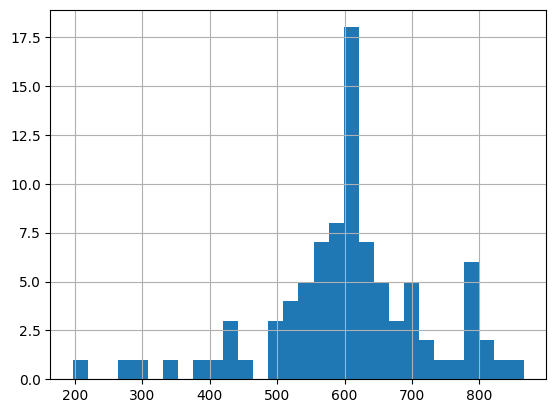

In [22]:
veh_df['headway'].hist(bins=30)

In [58]:
veh_df[veh_df['headway']>1500]

,direction,stop,arrival_time,departure_time,load,boardings,alightings,veh_id,headway
12,out,3,1923.0,1932.0,7,2,0,0,1566.0
13,out,5,2025.0,2042.0,7,3,3,0,1543.0
14,out,6,2178.0,2197.0,0,0,7,0,1567.0
15,in,0,2400.0,2407.0,1,1,0,0,1780.0
16,in,1,2489.0,2489.0,1,0,0,0,1693.0
17,in,3,2596.0,2596.0,1,0,0,0,1668.0
18,in,5,2716.0,2716.0,1,0,0,0,1548.0
19,in,6,2818.0,2825.0,0,0,1,0,1539.0
20,out,0,3000.0,3007.0,1,1,0,0,1706.0
21,out,1,3227.0,3234.0,2,1,0,0,1777.0


In [45]:
veh_df

direction  stop  arrival_time  departure_time  load  \
direction stop                                                           
in        0    5          in     0         620.0           633.0     4   
               57         in     0        1202.0          1202.0     0   
               67         in     0        2179.0          2196.0     6   
               15         in     0        2400.0          2407.0     1   
               77         in     0        3184.0          3193.0     2   
...                      ...   ...           ...             ...   ...   
out       6    86        out     6        4260.0          4271.0     0   
               34        out     6        4661.0          4670.0     0   
               96        out     6        5301.0          5312.0     0   
               44        out     6        6138.0          6153.0     0   
               106       out     6        6422.0          6433.0     0   

                    boardings  alightings  veh_id  headway  
direction stop                                              
in        0    5            4           0       0      NaN  
               57           0           0       1    582.0  
               67           6           0       1    977.0  
               15           1           0       0    221.0  
               77           2           0       1    784.0  
...                       ...         ...     ...      ...  
out       6    86           0           3       1    752.0  
               34           0           2       0    401.0  
               96           0           3       1    640.0  
               44           0           5       0    837.0  
               106          0           3       1    284.0  

[109 rows x 9 columns]

In [41]:
headway_df

,direction,stop,headway
0,in,0,447.0
1,in,1,386.0
2,in,3,870.0
3,in,5,808.0
4,in,6,879.0
5,out,0,697.0
6,out,1,768.0
7,out,3,360.0
8,out,5,399.0
9,out,6,284.0


In [26]:
print([(direction, p.origin, p.dest, p.arrival_time, p.boarding_time, p.alight_time) for p in route.archived_pax])

[('out', 1, 3, 94.0, 136.0, 360.0), ('out', 1, 6, 23.0, 136.0, 650.0)]
